<img src="http://www.ensai.fr/files/_media/images/l_ecole/Partenaires/Ecoles/ensae_logo_dev.png" width="400" height="80" />
<br>
<div class="monika" align="center" style="font-size:200%"> Données massives </div>
<br>
<div style="text-align: center"> Raphaël Berdugo & Mathis Linger </div>

We worked on the paper 'Trofimov, I., Genkin, A. (2014). Distributed coordinate descent for l1-regularized logistic regression. arXiv:1411.6520'.

The aim of this paper is to solve logistic regression with L1-regularization in a distributed setting. In this notebook, we propose an implementation of the algorithm using CPU distribution.

In what follow, we introduce definitions and algorithms to which we will refer in the class's structure explanation.

__Definition 1:__ Optimal variations of coefficients' features

The optimal variation of the coefficient for variable $j$ is given by
<br>
$\Delta\beta_j^* = \frac{T(\sum\limits_{i=1}^n w_ix_{ij}q_i,\lambda)}{\sum\limits_{i=1}^nw_ix^2_{ij}}-\beta_j$

where
<br>
$T(x,a) = \text{sgn}(x)\max(|x|-a, 0)$
<br>
$q_i = z_i - \Delta\beta^Tx_i+(\beta_j+\Delta\beta_j)x_{ij}$
<br>
$z_i = \frac{(y_i+1)/2-p(x_i)}{w_i}$
<br>
$w_i = p(x_i)(1-p(x_i))$
<br>
$p(x_i) = \frac{1}{1+e^{-\beta^Tx_i}}$

__Definition 2:__ Loss function, penalty and objective

The loss function is defined as
<br>
$L(\beta) = \sum\limits_{i=1}^nlog(1+e^{-y_i\beta^Tx_i})$

The penalty if defined as
<br>
$P(\beta) = \lambda ||\beta||_1$

The objective is therefore
<br>
$f(\beta) = L(\beta) + P(\beta)$

__Algorithm 1:__ Line search procedure

1. If $\alpha = 1$ yields sufficient relative decrease in the objective, return $\alpha=1$

2. Find $\alpha_{init} = argmin_{\delta<\alpha<1} \text{  } f(\beta+\alpha\Delta\beta)$, $\delta >0$

3. Armijo rule: Let $\alpha$ be the largest element of the sequence $\{\alpha_{init}b^j\}_{j=0,1,...}$ satisfying
<br>
<br>
<center>
$f(\beta+\alpha\Delta\beta) \leq f(\beta)+\alpha\sigma D$
</center>

where $0<b<1$, $0<\sigma<1$, $0\leq\gamma<1$, and

<center>
$D = \nabla L(\beta)^T \Delta\beta+\gamma\Delta\beta^T\tilde{H}\Delta\beta+\lambda(||\beta-\Delta\beta||_1-||\beta||_1)$
</center>

return $\alpha$

What is difficult here is to compute $D$. In what follows, I explain how is computed $\nabla L(\beta)$ and $\tilde{H}$ and then $D$:

- __Definition 3:__ Gradient of the loss function

$\nabla L(\beta) = \frac{dL(\beta)}{d\beta} = (\frac{dL(\beta)}{d\beta_1}, \frac{dL(\beta)}{d\beta_2},...) \text{  with  } L(\beta) = \sum\limits_{i=1}^nlog(1+e^{-y_i\beta^Tx_i}) = \sum\limits_{i=1}^nlog(1+e^{-y_i(\beta_{1i}x_{1i}+\beta_{2i}x_{2i}+...)})$

So it comes that $\nabla L(\beta) = \bigg(\sum\limits_{i=1}^n\frac{-y_ix_{1i}e^{-y_i(\beta_{1i}x_{1i}+\beta_{2i}x_{2i}+...)}}{1+e^{-y_i(\beta_{1i}x_{1i}+\beta_{2i}x_{2i}+...)}}, \sum\limits_{i=1}^n\frac{-y_ix_{2i}e^{-y_i(\beta_{1i}x_{1i}+\beta_{2i}x_{2i}+...)}}{1+e^{-y_i(\beta_{1i}x_{1i}+\beta_{2i}x_{2i}+...)}},...\bigg) = \bigg(\sum\limits_{i=1}^n\frac{-y_ix_{1i}e^{-y_i\beta^Tx_i}}{1+e^{-y_i\beta^Tx_i}}, \sum\limits_{i=1}^n\frac{-y_ix_{2i}e^{-y_i\beta^Tx_i}}{1+e^{-y_i\beta^Tx_i}},...\bigg)$

- __Definition 3:__ Matrix $\tilde{H}$ and gradient second of the loss function

Let us split $p$ input features into $M$ disjoint sets $S_k$

$\tilde{H}$ is such that $(\tilde{H})_{jl} =
\begin{cases}
(\nabla^2L(\beta))_{jl},& \text{if } \exists m:j,l \in S_m\\
0,              & \text{otherwise}
\end{cases}$
    
with $(\nabla^2L(\beta))_{jl} = \sum\limits_{i=1}^n\frac{y_i^2x_{ji}x_{li}e^{-y_i\beta^Tx_i}(1+e^{-y_i\beta^Tx_i}) - y_i^2x_{li}x_{ji}e^{-2y_i\beta^Tx_i}}{(1+e^{-y_i\beta^Tx_i})^2}$

__Algorithm 2:__ Overall procedure of d-GLMNET

$\beta \leftarrow 0$

Split ${1, ..., p}$ into $M$ disjoint sets $S_1, ..., S_M$

Repeat until convergence:

1. Do in parallel over $M$ machines

2. $\text{       }$Minimize $L(\beta + \Delta\beta^m) + ||\beta + \Delta\beta^m||_1$ with respect to $\Delta\beta^m$

3. $\Delta\beta \leftarrow \sum\limits_{m=1}^M \Delta\beta^m$

4. Find $\alpha \in (0,1]$ by the line search procedure (Algorithm 1)

5. $\beta \leftarrow \beta + \alpha \Delta\beta$

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from scipy import optimize
from collections import OrderedDict
import multiprocessing


class dGLMNET:
    
    """- Lasso parameter
    regularization: float
    Regularization for the Lasso
    - Line search parameters
    sufficient_decrease: float, default 10
    Minimum decrease in the objective for which we keep a step of 1 for the gradient descent
    delta: float, between 0 and 1, default .2
    Minimum value for the initial step before search
    b: float, between 0 and 1, default .5
    Multiplicator of the step to find the good one (used in the Armijo rule)
    sigma: float, between 0 and 1, default .01
    Used in the Armijo rule
    gamma: float, between 0 and 1, default 0
    Used in the Armijo rule"""
    
    def __init__(self, regularization = 1., sufficient_decrease = 10, delta = .2, b = .5, sigma = .01, gamma = 0):
        self.regularization = regularization
        self.sufficient_decrease = sufficient_decrease
        self.delta = delta
        self.b = b
        self.sigma = sigma
        self.gamma = gamma
    
    # Definition 1: Optimal variations of coefficients' features
        
    def T(self, u, a):
        """u: float
        a: float"""
        return np.sign(u) * max(np.abs(u) - a, 0)
    
    def pi(self, beta, xi):
        """beta: array-like, shape (n_features,)
        Vector of coefficients
        xi: array-like, shape (n_features,)
        Features' vector for observation i"""
        return 1 / (1 + np.exp(-np.dot(beta, xi)))
    
    def wi(self, beta, xi):
        """beta: array-like, shape (n_features,)
        Vector of coefficients
        xi: array-like, shape (n_features,)
        Features' vector for observation i"""
        return self.pi(beta, xi) * (1 - self.pi(beta, xi))
    
    def zi(self, beta, xi, yi):
        """beta: array-like, shape (n_features,)
        Vector of coefficients
        xi: array-like, shape (n_features,)
        Features' vector for observation i
        yi: integer
        Label of target for observation i"""
        return (((yi + 1) / 2) - self.pi(beta, xi)) / self.wi(beta, xi)
    
    def qi(self, beta, dbeta, xi, yi, j):
        """beta: array-like, shape (n_features,)
        Vector of coefficients
        dbeta: array-like, shape (n_features,)
        Vector of coefficients' variations
        xi: array-like, shape (n_features,)
        Features' vector for observation i
        yi: integer
        Label of target for observation i
        j: integer
        Position of the considered feature (in X)"""
        return self.zi(beta,xi,yi) - np.dot(dbeta,xi) + (beta[j] + dbeta[j])*xi[j]
    
    def dbetaj_optimal(self, beta, dbeta_k, X, y, j):
        """Formula given in the paper to find the optimal variation of the coefficient of a given variable
        beta: array-like, shape (n_features,)
        Vector of coefficients
        dbeta_k: array-like, shape (n_features,)
        Vector of coefficients' variations
        X: {array-like, sparse matrix}, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and n_features is the number of features
        Y:  array-like, shape (n_samples,)
        Target vector relative to X
        j: integer
        Position of the considered feature (in X)"""
        w = np.array([self.wi(beta,X[i,:]) for i in range(X.shape[0])])
        q = np.array([self.qi(beta, dbeta_k, X[i,:], y[i], j) for i in range(X.shape[0])])
        q = np.nan_to_num(q)
        wq = np.array([w[i] * q[i] for i in range(len(q))])
        num = self.T(np.dot(wq,X[:,j]), self.regularization)
        den = np.dot(w, np.square(X[:,j]))
        return (num/den) - beta[j]

    # Distribute features across cores
    
    def partition_distributed_setup(self, p, M):
        """Distribute features across cores
        p: integer
        Number of features in our dataset
        M: integer
        Number of cores over which we want to parallelize"""
        original_set = np.arange(p)
        S = []
        for i in range(int(p/M) + np.count_nonzero(p%M)):
            if i < int(p/M) : 
                choosen = np.random.choice(original_set, M, replace=False)
                S.append(choosen)
                original_set = np.setdiff1d(original_set, choosen) # J'ai changé np.delete par np.setdiff1d
            else :
                choosen = np.random.choice(original_set, p%M ,replace=False)
                S.append(choosen)
        return np.array(S)
    
    # Definition 2: Loss function, penalty and objective
    
    def loss_function(self, X, Y, beta):
        """Loss function
        X: {array-like, sparse matrix}, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and n_features is the number of features
        Y:  array-like, shape (n_samples,)
        Target vector relative to X"""
        y_beta_x = np.multiply(Y,X.dot(beta))
        return sum(np.log(1 + np.exp(-y_beta_x)))

    def penalty(self, beta):
        """Penalty
        beta: array-like, shape (n_features,)
        Vector of coefficients"""
        return self.regularization * np.linalg.norm(beta, ord=1)
    
    def functional(self, X, Y, beta):
        """Objective we want to minimize
        X: {array-like, sparse matrix}, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and n_features is the number of features
        Y:  array-like, shape (n_samples,)
        Target vector relative to X
        beta: array-like, shape (n_features,)
        Vector of coefficients"""
        return self.loss_function(X, Y, beta) + self.penalty(beta)
    
    # Algorithm 1: Line search procedure
    
    ## Definition 3: Gradient of the loss function
    
    def gradient_loss(self, X, Y, beta):
        """Gradient of the loss function
        X: {array-like, sparse matrix}, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and n_features is the number of features
        Y:  array-like, shape (n_samples,)
        Target vector relative to X
        beta: array-like, shape (n_features,)
        Vector of coefficients"""
        gradient = []
        for j in range(len(beta)):
            y_beta_x = Y * X.dot(beta)
            y_xj = Y * X[:,j]
            gradient_betaj = sum((-y_xj * np.exp(-y_beta_x)) / (1 + np.exp(-y_beta_x)))
            gradient.append(gradient_betaj)
        return np.array(gradient)
    
    ## Definition 3: Matrix H_tilde and gradient second of the loss function
    
    def second_gradient_loss(self, X, Y, beta, variable_j, variable_l):
        """Gradient second of the loss function
        X: {array-like, sparse matrix}, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and n_features is the number of features
        Y:  array-like, shape (n_samples,)
        Target vector relative to X
        beta: array-like, shape (n_features,)
        Vector of coefficients
        variable_j: integer
        variable_l: integer
        Variables for which we compute the gradient second"""
        y_beta_x = Y * X.dot(beta)
        ysq_xj_xl = Y**2 * (X[:,variable_j] * X[:,variable_l])
        gradient_betajl = sum((ysq_xj_xl * np.exp(-y_beta_x) * (1 + np.exp(-y_beta_x)) + Y * (X[:,variable_l]) *
                               np.exp(-y_beta_x) * (-Y * (X[:,variable_j]) * np.exp(-y_beta_x))) /
                              (1 + np.exp(-y_beta_x))**2)
        return gradient_betajl
    
    def H_tilde(self, X, Y, beta):
        """Matrix used in the Armijo rule
        X: {array-like, sparse matrix}, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and n_features is the number of features
        Y:  array-like, shape (n_samples,)
        Target vector relative to X
        beta: array-like, shape (n_features,)
        Vector of coefficients"""
        # Combination of all possible indexes
        iterator = list(itertools.product([i for i in range(len(beta))], [i for i in range(len(beta))]))
        # Initialize H_tilde matrix
        H_tilde = np.empty((len(beta),len(beta),))
        H_tilde[:] = np.nan
        for i in iterator:
            H_tilde[i[0],i[1]] = self.second_gradient_loss(X, Y, beta, i[0], i[1])
        return H_tilde
    
    def D(self, X, Y, beta, delta_B):
        """Used to find the good gradient step in the Armijo rule
        X: {array-like, sparse matrix}, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and n_features is the number of features
        Y:  array-like, shape (n_samples,)
        Target vector relative to X
        beta: array-like, shape (n_features,)
        Vector of coefficients
        delta_B: array-like, shape (n_features,)
        Vector of gradient steps"""
        return self.gradient_loss(X,Y,beta).dot(delta_B) + self.gamma * delta_B.dot(self.H_tilde(X,Y,beta)).dot(delta_B)\
        + self.regularization * (np.linalg.norm(beta-delta_B, ord=1) - np.linalg.norm(beta, ord=1))
    
    def line_search(self, X, Y, beta, delta_B):
        """Line search procedure
        X: {array-like, sparse matrix}, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and n_features is the number of features
        Y:  array-like, shape (n_samples,)
        Target vector relative to X
        beta: array-like, shape (n_features,)
        Vector of coefficients
        delta_B: array-like, shape (n_features,)
        Vector of gradient steps"""
        if self.functional(X, Y, beta) - self.functional(X, Y, beta+delta_B)\
        > self.sufficient_decrease:
            return 1
        else:
            result = optimize.minimize_scalar(lambda x: self.functional(X, Y, beta+(x*delta_B)),\
                                              bounds=(self.delta,1), method='Bounded')
            alpha_in = result.x
            alpha = alpha_in
            while self.functional(X, Y, beta+alpha*delta_B) > self.functional(X, Y, beta,) + \
                                              alpha*self.sigma*self.D(X, Y, beta, delta_B):
                alpha *= self.b
            return alpha
    
    # Algorithm 2: Overall procedure of d-GLMNET
    
    def fit(self, X, y, M, max_iter = 60, relative_decrease = .0005, metrics = False):
        """To fit a Lasso Logistic regression over M cores
        X: {array-like, sparse matrix}, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and n_features is the number of features
        Y:  array-like, shape (n_samples,)
        Target vector relative to X
        M: integer
        Number of cores used for computations
        max_iter: integer, default 60
        Maximum number of iterations of the algorithm
        relative_decrease: float, default .0005
        Relative decrease in the objective necessary to stop the algorithm
        metrics: boolean, default False
        Compute metrics_report or not"""
        # Initialization of the loop
        p = X.shape[1]
        beta = np.zeros(p)
        functional_previous = self.functional(X,y,beta)
        functional_ = 0
        dbeta_M = np.zeros((M, p))
        # Do the distribution of the features over the M cores
        self.S = self.partition_distributed_setup(p, M)
        pool = multiprocessing.Pool(M)
        # Set metrics report
        count = 0
        self.metrics_report_ = OrderedDict()
        
        while (count < max_iter) and ((functional_previous - functional_) / functional_previous > relative_decrease):
            # 1. Do in parallel over M machines
            for i in self.S:
            # 2. Minimize the objective
                results = [pool.apply_async(self.dbetaj_optimal, (beta, dbeta_M[k,:], X, y, j,)) for k,\
                           j in enumerate(i)]
                for index, result in enumerate(results):
                    dbeta_M[index,i[index]] = result.get()
            dbeta = np.sum(dbeta_M, 0)
            # 4. Find the rate using line search
            rate = self.line_search(X, y, beta, dbeta)
            # 5. Find the new betas
            functional_previous = self.functional(X,y,beta)
            beta = beta + rate * dbeta
            count += 1
            # Create a metrics report
            if metrics == True:
                self.metrics_report_.update({'Iteration {}'.format(count): list(beta) + [self.loss_function(X,y,beta),\
                                                                            self.functional(X,y,beta), rate]})
        self.coefficients_ = beta
        
    def display_metrics(self, line_width = 1, coef_legend = False):
        """Display metrics_report (metrics_report = True needed in fit method)
        line_width: integer
        Line width of the plots, default 1
        coef_legend: boolean, default False
        Display the legend for the coefficients plot or not"""
        df = pd.DataFrame.from_dict(self.metrics_report_, orient='index')
        df.columns = ['Feature {}'.format(i+1) for i in range(df.shape[1]-3)] + ['Loss', 'Objective', \
                                                                              'Rate for the gradient step']
        df[['Loss', 'Objective']].plot(lw = line_width, use_index = False, title = \
                                       'Evolution of the loss and objective functions')
        plt.xlabel('Iterations')
        df.iloc[:,:(df.shape[1]-3)].plot(lw = line_width, use_index = False, title ='Evolution of the coefficients',\
                                         legend = coef_legend)
        plt.xlabel('Iterations')
        display(df)
    
    def predict_proba(self, X):
        """To do probabilities' predictions
        X: {array-like, sparse matrix}, shape (n_samples, n_features)
        Vector to predict, where n_samples is the number of samples and n_features is the number of features"""
        return (X.dot(self.coefficients_) + 1) / 2
    
    def predict(self, X, threshold = .5):
        """To do labels' predictions
        X: {array-like, sparse matrix}, shape (n_samples, n_features)
        Vector to predict, where n_samples is the number of samples and n_features is the number of features
        threshold: float, default .5
        The probability above which we predict the positive label"""
        prediction = self.predict_proba(X)
        prediction[prediction >= threshold] = 1
        prediction[prediction < threshold] = -1
        return prediction

Here we simulate data and compare the prediction's accuracy of our distributed algorithm with the one of the scikit-learn logistic regression (using the same penalization).

In [9]:
#Simulation 
from scipy.linalg.special_matrices import toeplitz
n = 1000
p = 50
corr = 0.8
std = 1
cov = toeplitz(corr ** np.arange(0, p))
X = np.random.multivariate_normal(np.zeros(p),cov,size=n)
noise = std * np.random.randn(n)
idx = np.arange(1,p+1)
beta_truth = (-1) ** (idx - 1) * np.exp(-idx / 10.)
y = np.sign(X.dot(beta_truth) + noise)

In [10]:
test = dGLMNET()

In [11]:
test.fit(X, y, 3, 20, .0005, True)

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,...,Feature 44,Feature 45,Feature 46,Feature 47,Feature 48,Feature 49,Feature 50,Loss,Objective,Rate for the gradient step
Iteration 1,0.652798,-0.216780,0.339478,-0.144510,0.155341,-0.247881,-0.009915,-0.143344,0.003817,-0.144779,...,-0.018876,-0.014959,-0.042514,2.865165e-02,-0.027008,0.000000,-1.033728e-02,607.334034,610.544247,1.000000
Iteration 2,1.012612,-0.639584,0.515202,-0.455262,0.369191,-0.384079,0.131766,-0.145711,0.119830,-0.263575,...,-0.014259,-0.010993,-0.103484,7.003904e-02,-0.054800,0.026645,-2.459117e-02,572.552699,578.690473,1.000000
Iteration 3,1.267850,-0.851477,0.637738,-0.632448,0.520937,-0.459956,0.073090,-0.134985,0.154054,-0.322882,...,-0.027764,-0.018506,-0.119147,7.963176e-02,-0.046014,0.053265,-4.640906e-04,549.417213,557.377640,0.516691
Iteration 4,1.573193,-1.111977,0.842946,-0.899438,0.772958,-0.563232,0.140902,-0.095663,0.180319,-0.398832,...,-0.027313,-0.019328,-0.180838,7.033763e-02,-0.076081,0.083623,-1.800582e-02,536.664978,546.971786,0.748989
Iteration 5,1.682388,-1.238987,0.923685,-1.050050,0.957433,-0.652822,0.116418,-0.081914,0.192317,-0.461414,...,-0.034763,-0.010531,-0.168619,5.851347e-02,-0.065328,0.104249,-1.932754e-03,531.624596,543.121889,0.504945
Iteration 6,1.760944,-1.334374,1.010452,-1.186791,1.162576,-0.766125,0.149938,-0.079564,0.206124,-0.522876,...,-0.042254,0.004563,-0.167851,3.484812e-02,-0.086940,0.114672,-1.319588e-02,528.629341,541.361772,0.596975
Iteration 7,1.781847,-1.387606,1.056708,-1.268440,1.331797,-0.885778,0.151983,-0.094918,0.225770,-0.569197,...,-0.054104,0.020711,-0.133927,1.788683e-02,-0.088662,0.120772,-5.397305e-03,526.715147,540.286280,0.590986
Iteration 8,1.781267,-1.412860,1.095043,-1.301180,1.439272,-0.985549,0.184275,-0.117613,0.243088,-0.589269,...,-0.067451,0.031646,-0.113626,7.648199e-03,-0.101104,0.118653,-7.917430e-03,525.475176,539.698740,0.572412
Iteration 9,1.747294,-1.433548,1.123906,-1.288689,1.515802,-1.108820,0.224858,-0.165011,0.271092,-0.590246,...,-0.092454,0.038469,-0.072227,1.378903e-03,-0.102857,0.116497,-3.458124e-08,523.706755,538.492555,0.999996
Iteration 10,1.732454,-1.448375,1.153706,-1.233072,1.469589,-1.142544,0.316767,-0.204622,0.284417,-0.562773,...,-0.111903,0.032277,-0.064584,6.022682e-09,-0.116866,0.112003,-1.290210e-02,521.251000,536.330020,0.999996


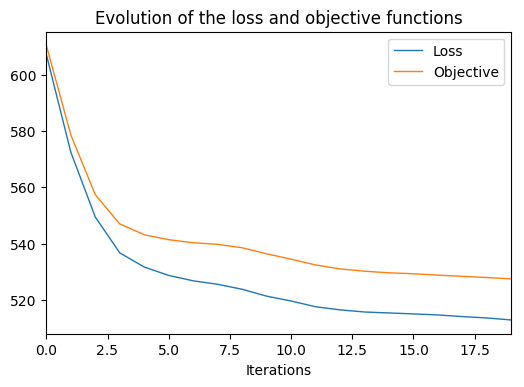

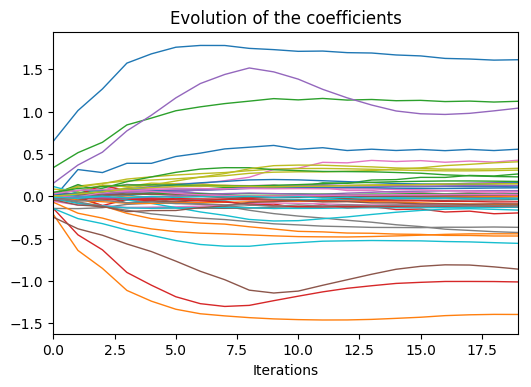

In [5]:
test.display_metrics()

In [6]:
test.predict(X)

array([ 1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,
        1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1., -1., -1.,  1.,
       -1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1.,
        1., -1., -1., -1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,
       -1., -1.,  1.,  1.,  1., -1.,  1., -1., -1., -1., -1.,  1.,  1.,
       -1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1.,  1., -1.,
       -1.,  1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1.,  1.,
        1., -1., -1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,
       -1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,
        1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,
       -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1.,
       -1., -1., -1.,  1., -1.,  1., -1., -1., -1.,  1.,  1., -1

In [7]:
# Our error
sum(abs(test.predict(X) - y) / 2) / X.shape[0]

0.26600000000000001

In [8]:
# The sklearn error
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=3)
lr.fit(X, y)

sum(abs(lr.predict(X) - y) / 2) / X.shape[0]

0.26300000000000001

![Alt Text](https://media.giphy.com/media/b5LTssxCLpvVe/giphy.gif)

Now, let us compare on real data the accuracy yielded by our distributed implementation with the one yielded by the scikit-learn logistic lasso.

In [9]:
data = pd.read_csv('breast_cancer.txt', sep=',', header=None, index_col=0)
data.index = [i for i in range(data.shape[0])]

In [10]:
X = data.iloc[:,1:].as_matrix()
y = data.iloc[:,0].ravel()
y = (y == 'M').astype(np.int_)
y[y ==0] = -1

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# Sklearn error
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=3)
lr.fit(X_train, y_train)
sum(abs(lr.predict(X_test) - y_test)) / X_test.shape[0]

0.081871345029239762

In [1]:
# Our error
our_lasso = dGLMNET()
our_lasso.fit(X_train, y_train, 3, 5, .005, True)
sum(abs(our_lasso.predict(X_test) - y_test)) / X_test.shape[0]

0.09134100422921071

The 2 error rates are very close.